# Bank Customer Churn Prediction

December 2022

Brian Morris

### **Table of Contents**
1. [Objective](#obj)
2. [Load and explore data](#load)
3. [Enrich and analyse data](#analyse)
4. [Model, predict, and evaluate](#model)
5. [Deep learning model](#deep)
6. [Report conclusion and final results](#report)

New packages I used for this project:

In [1]:
# %pip install feature-engine
# %pip install lightgbm

In [4]:
# Import libraries

# EDA and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

# stacking
from sklearn.ensemble import StackingClassifier

# preprocessing
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.encoding import OneHotEncoder # for one hot encoding with feature-engine
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer

# deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.neural_network import MLPClassifier

# interpreting the model
from lime.lime_tabular import LimeTabularExplainer
import shap

# Saving the model
from joblib import dump, load

%matplotlib inline
plt.style.use('seaborn')

<a id='obj'></a>
# 1. Objective

Banks have commited a lot of time and resources into onboaring their customers, as well as, nurturing their customer's growth. The costs of onboarding new customers is constantly increasing and the bank wants to not only maintain its marketshare but also continue to grow. This means that one of the most important goals is to improve the retention rate of these customers they worked so hard to build a relationship with.

Our goal is to find patterns among customers that churn. Then to provide an early indication for similarly behaving customers. If we can target these customers early we have a greater chance of retaining them as a customer. This can be accomplished by developing loyalty programs and retention campaigns to keep as many customers as possible.

We also want to understand the factors that impact churn. By understanding these factors we can generate a churner profile that we can use to evaluate all customers old and new.

> Demonstrate how machine learning models can be strategically applied to attrition (churn). Improve retention rate, provide an early indication of churn, and understand the factors that impact churn (build a churner profile).

Why do customers churn?

Some reasons are:

- Competitor's technology is easier to use
- Rate competition
- Better customer service elsewhere
- **Patterns of behavior in their transactions**
- **Profile type**
- **Engagement with the company**
- **Product relationships**

Data source: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

<a id='load'></a>
# Load and explore data

**Feature dictionary:**

- **RowNumber**: corresponds to the record (row) number and has no effect on the output.
- **CustomerId**: contains random values and has no effect on customer leaving the bank.
- **Surname**: the surname of a customer has no impact on their decision to leave the bank.
- **CreditScore**: can have an effect on customer churn, since a customer with a higher credit score is less likely to leave.
- **Geography**: a customer’s location can affect their decision to leave.
- **Gender**: it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- **Age**: this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- **Tenure**: refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave.
- **Balance**: also a very good indicator of customer churn, as people with a higher balance are less likely to leave.
- **NumOfProducts**: refers to the number of products that a customer has purchased through the bank.
- **HasCrCard**: denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave.
- **IsActiveMember**: active customers are usually less likely to leave.
- **EstimatedSalary**: as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- **Exited**: whether or not the customer left the bank.


In [5]:
# Load in our data
df = pd.read_csv('churn.csv')

In [6]:
# Let's check out the shape of the data
df.shape

(10000, 14)

In [7]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [8]:
# The 'RowNumber' column is just an index, let's drop it
df.drop('RowNumber', axis=1, inplace=True)

In [9]:
df.head()

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0

In [10]:
df.head().T

0          1          2         3          4
CustomerId        15634602   15647311   15619304  15701354   15737888
Surname           Hargrave       Hill       Onio      Boni   Mitchell
CreditScore            619        608        502       699        850
Geography           France      Spain     France    France      Spain
Gender              Female     Female     Female    Female     Female
Age                     42         41         42        39         43
Tenure                   2          1          8         1          2
Balance                0.0   83807.86   159660.8       0.0  125510.82
NumOfProducts            1          1          3         2          1
HasCrCard                1          0          1         0          1
IsActiveMember           1          1          0         0          1
EstimatedSalary  101348.88  112542.58  113931.57  93826.63    79084.1
Exited                   1          0          1         0          0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


We have 13 features. Three are in object (text) format, and the other 10 are numeric.

In [12]:
df.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Let's get a quick description of all the numeric features

In [13]:
df.describe()

CustomerId   CreditScore           Age        Tenure        Balance  \
count  1.000000e+04  10000.000000  10000.000000  10000.000000   10000.000000   
mean   1.569094e+07    650.528800     38.921800      5.012800   76485.889288   
std    7.193619e+04     96.653299     10.487806      2.892174   62397.405202   
min    1.556570e+07    350.000000     18.000000      0.000000       0.000000   
25%    1.562853e+07    584.000000     32.000000      3.000000       0.000000   
50%    1.569074e+07    652.000000     37.000000      5.000000   97198.540000   
75%    1.575323e+07    718.000000     44.000000      7.000000  127644.240000   
max    1.581569e+07    850.000000     92.000000     10.000000  250898.090000   

       NumOfProducts    HasCrCard  IsActiveMember  EstimatedSalary  \
count   10000.000000  10000.00000    10000.000000     10000.000000   
mean        1.530200      0.70550        0.515100    100090.239881   
std         0.581654      0.45584        0.499797     57510.492818   
min         1.000000      0.00000        0.000000        11.580000   
25%         1.000000      0.00000        0.000000     51002.110000   
50%         1.000000      1.00000        1.000000    100193.915000   
75%         2.000000      1.00000        1.000000    149388.247500   
max         4.000000      1.00000        1.000000    199992.480000   

             Exited  
count  10000.000000  
mean       0.203700  
std        0.402769  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

We can see the average age of our customers is 39 and they have been with us for 5 years on average.

Are all the customer numbers unique?

In [14]:
df['CustomerId'].nunique()

10000

They are.

Let's get a quick description of the object features

In [15]:
df.describe(include=['O'])

Surname Geography Gender
count    10000     10000  10000
unique    2932         3      2
top      Smith    France   Male
freq        32      5014   5457

Are there any missing values?

In [16]:
df.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Now that we have done a quick view of our DataFrame, let's dig deeper into exploratory data analysis.

Let's get the unique counts for each column

In [17]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [18]:
print('Number of unique values in each column:')
for label in df.columns:
        print(f'{label}: {df[label].nunique()}')

Number of unique values in each column:
CustomerId: 10000
Surname: 2932
CreditScore: 460
Geography: 3
Gender: 2
Age: 70
Tenure: 11
Balance: 6382
NumOfProducts: 4
HasCrCard: 2
IsActiveMember: 2
EstimatedSalary: 9999
Exited: 2


Let's take a look at the value counts for the columns, but exclude `CustomerId`:

In [19]:
for label in df.drop('CustomerId', axis=1).columns:
    print(f'{label}: {df[label].value_counts()}')
    print('-' * 30)

Surname: Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64
------------------------------
CreditScore: 850    233
678     63
655     54
705     53
667     53
      ... 
404      1
351      1
365      1
417      1
419      1
Name: CreditScore, Length: 460, dtype: int64
------------------------------
Geography: France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64
------------------------------
Gender: Male      5457
Female    4543
Name: Gender, dtype: int64
------------------------------
Age: 37    478
38    477
35    474
36    456
34    447
     ... 
92      2
82      1
88      1
85      1
83      1
Name: Age, Length: 70, dtype: int64
------------------------------
Tenure: 2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dt

Let's visualize the features and look for useful hints.

How does our target label look:

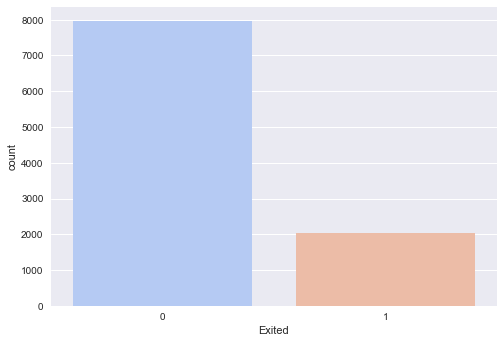

In [20]:
sns.countplot(data=df, x='Exited', palette='coolwarm');

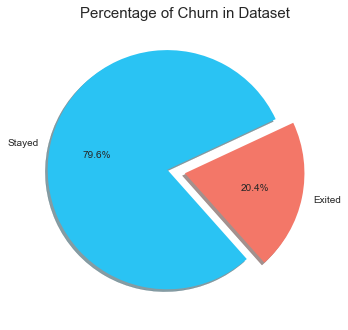

In [21]:
# In a pie chart view
sizes = df['Exited'].value_counts(sort=True)
colors = ['#2ac3f3', '#f37768'] 
explode = [0.15, 0]
labels= ['Stayed', 'Exited']

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=25)
plt.title('Percentage of Churn in Dataset', fontsize=15)
plt.show();

In [22]:
df['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Looks like we have an **imbalanced dataset**.

Let's check the rest of the features for correlation:

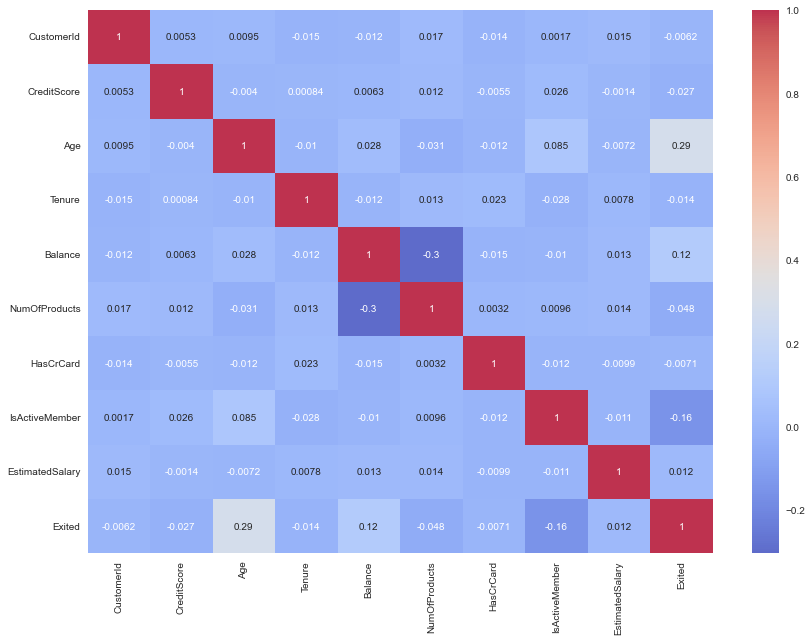

In [23]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', alpha=0.8)
plt.show();

List the correlation scores for our target label:

In [24]:
corr_results = df.corrwith(df['Exited']).abs().sort_values(ascending=False)
corr_results

Exited             1.000000
Age                0.285323
IsActiveMember     0.156128
Balance            0.118533
NumOfProducts      0.047820
CreditScore        0.027094
Tenure             0.014001
EstimatedSalary    0.012097
HasCrCard          0.007138
CustomerId         0.006248
dtype: float64

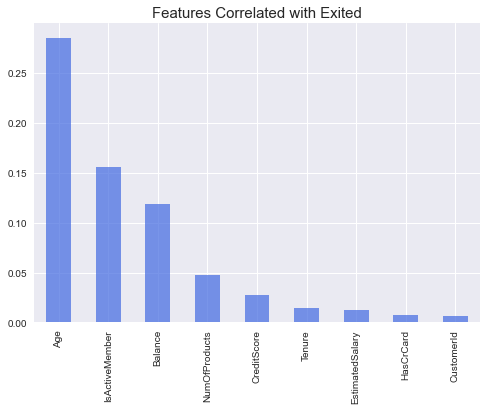

In [25]:
# Plot the features that correlate most with Exited 
corr_results[1:].plot(kind='bar', color=['royalblue'], alpha=0.7) # slice to drop the 'Exited' entry
plt.title('Features Correlated with Exited', fontsize=15);

There are not really any strong correlations with our label; however, `Age`, `IsActiveMember`, `Balance`, and `NumOfProducts` may play a role.

Are there any relationships between features we can find:

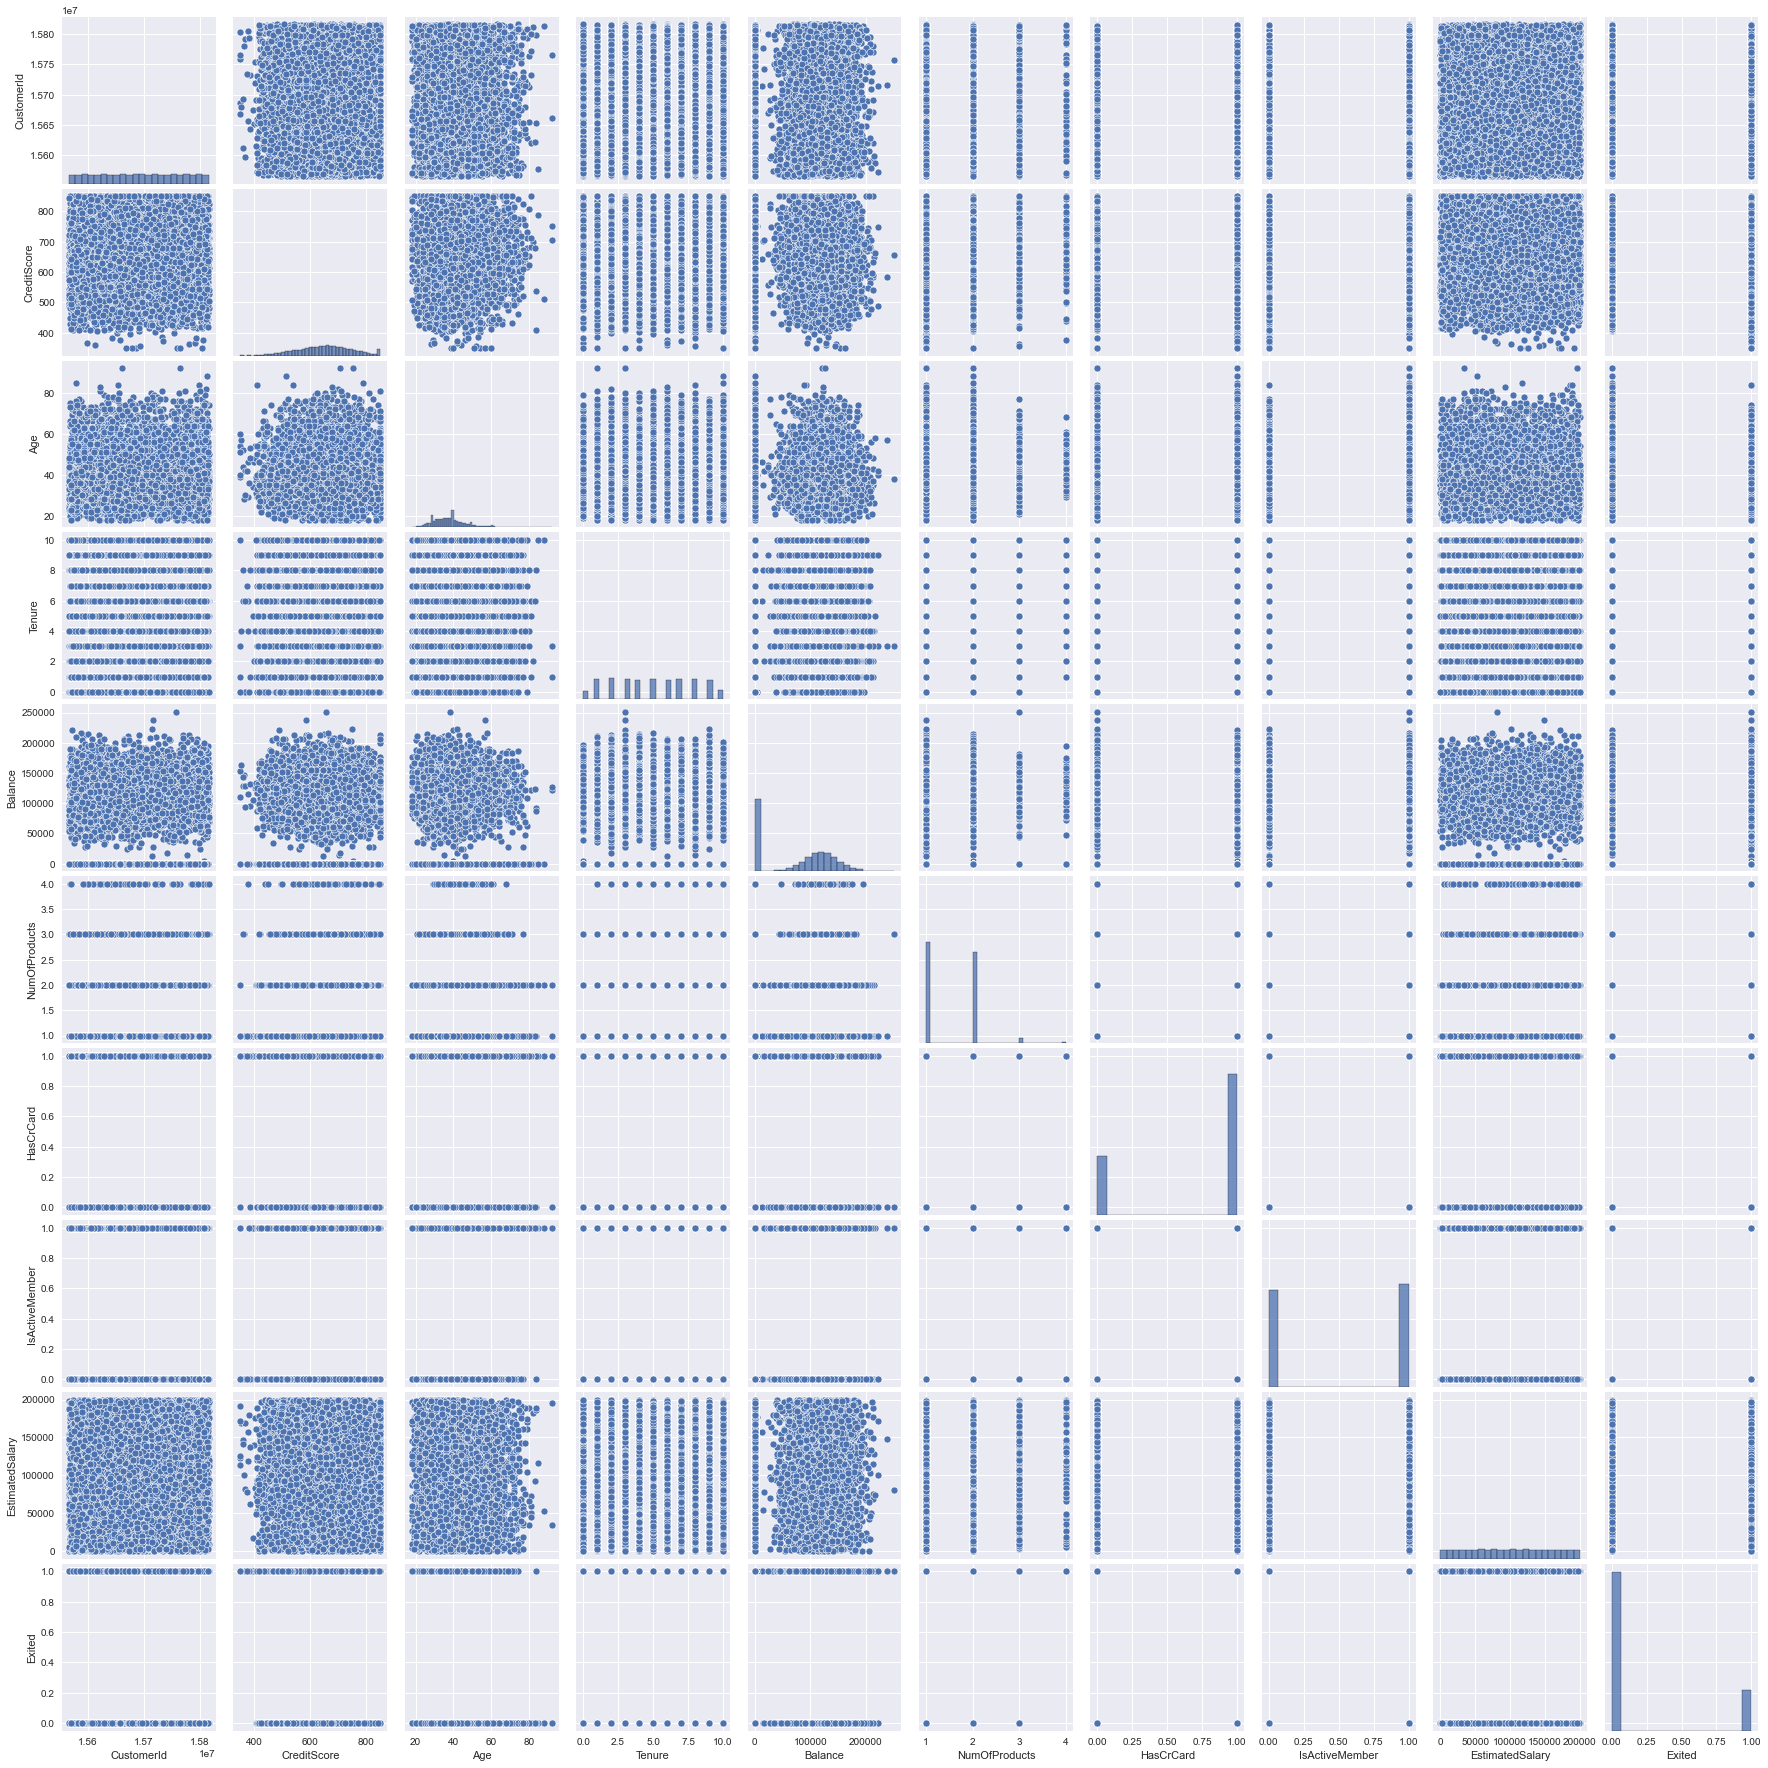

In [683]:
sns.pairplot(df);

Let's visualize our features in relation to our target label:

In [26]:
# Palette for presentation
pres_pal = ['#2ac3f3', '#f37768']

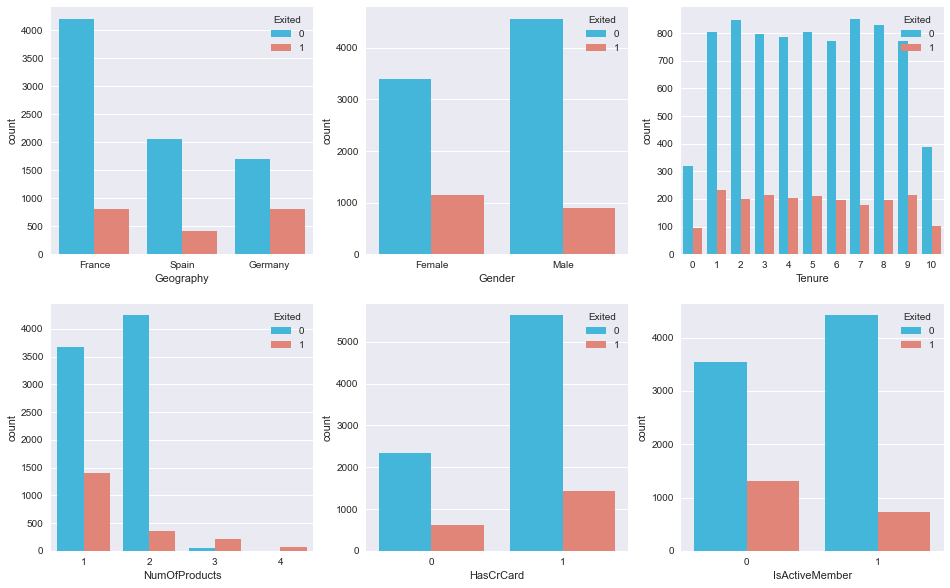

In [27]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))

sns.countplot(data=df, x='Geography', hue='Exited', ax=ax[0][0], palette=pres_pal)
sns.countplot(data=df, x='Gender', hue='Exited', ax=ax[0][1], palette=pres_pal)
sns.countplot(data=df, x='Tenure', hue='Exited', ax=ax[0][2], palette=pres_pal)
sns.countplot(data=df, x='NumOfProducts', hue='Exited', ax=ax[1][0], palette=pres_pal)
sns.countplot(data=df, x='HasCrCard', hue='Exited', ax=ax[1][1], palette=pres_pal)
sns.countplot(data=df, x='IsActiveMember', hue='Exited', ax=ax[1][2], palette=pres_pal);

It appears that the less products a customer has the more likely they are to leave. They are also most likely to leave if they are not an active member and are located in Germany.

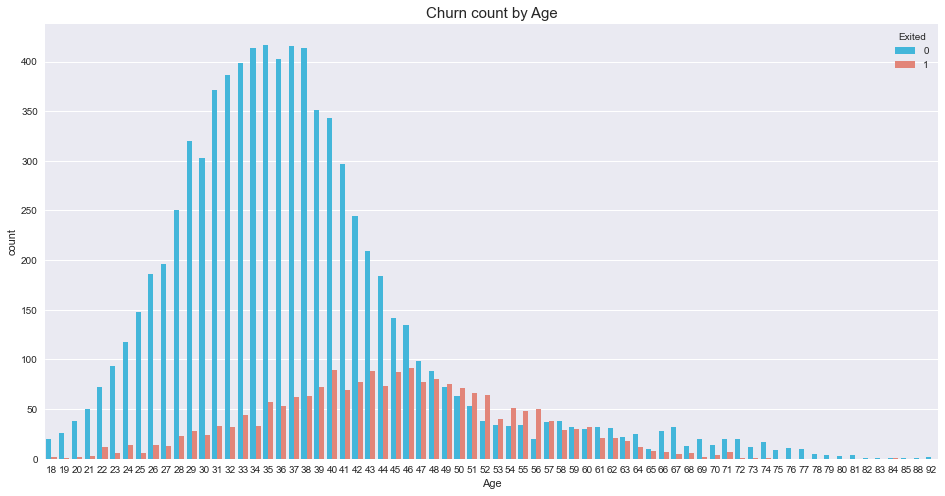

In [28]:
plt.figure(figsize=(16,8))
sns.countplot(data=df, x='Age', hue='Exited', palette=pres_pal)
plt.title('Churn count by Age', fontsize=15)
plt.show();

Customers age 49 begin to leave more than they stay. This can be seen up to age 60.
Customers in the late 30s and 40s show an increase in the amount leaving.

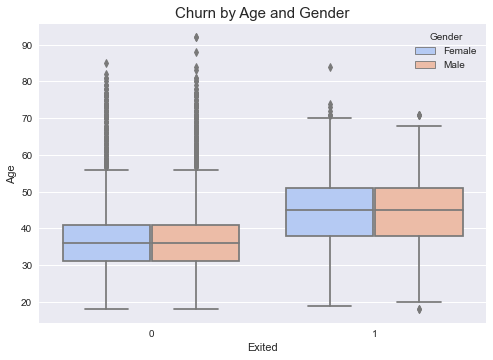

In [29]:
sns.boxplot(x='Exited', y='Age', hue='Gender', data=df, palette='coolwarm')
plt.title('Churn by Age and Gender', fontsize=15);

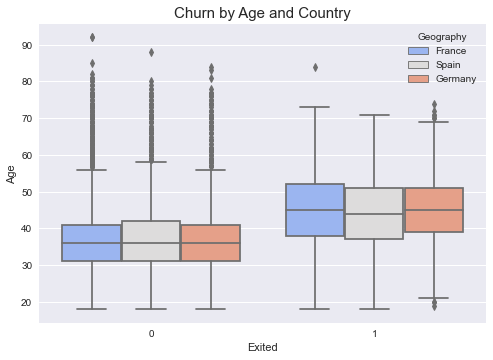

In [30]:
sns.boxplot(x='Exited', y='Age', hue='Geography', data=df, palette='coolwarm')
plt.title('Churn by Age and Country', fontsize=15);

Regarding `Age`, it looks like most of the customers who leave are in their late 30s, 40s, and early 50s. `Gender` looks balanced minus some outliers.

Let's also look at `CreditScore` by `Geography` for our target label.

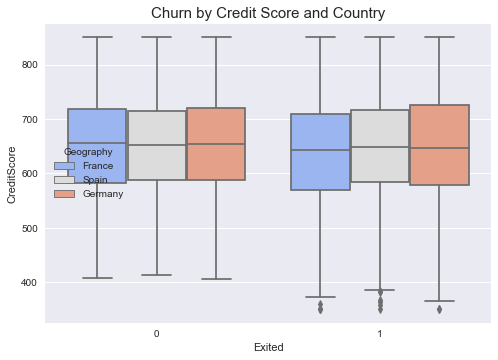

In [31]:
sns.boxplot(x='Exited', y='CreditScore', hue='Geography', data=df, palette='coolwarm')
plt.title('Churn by Credit Score and Country', fontsize=15);

We still need to take a look at `CreditScore`, `Balance` and `EstimatedSalary` compared to our target label:

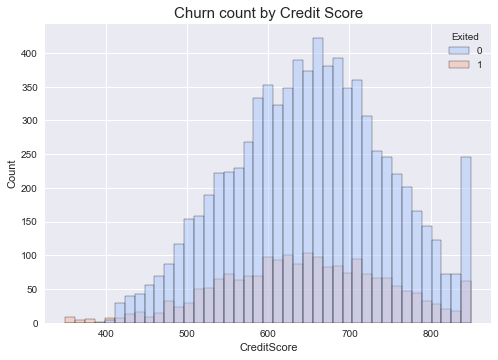

In [32]:
sns.histplot(data=df, x='CreditScore', hue='Exited', palette='coolwarm')
plt.title('Churn count by Credit Score', fontsize=15);

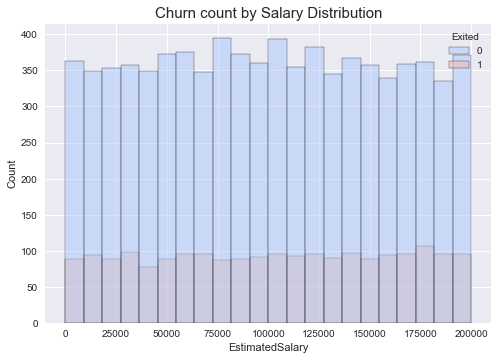

In [33]:
sns.histplot(data=df, x='EstimatedSalary', hue='Exited', palette='coolwarm')
plt.title('Churn count by Salary Distribution', fontsize=15);

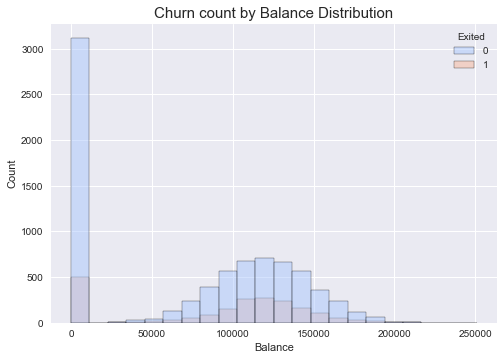

In [34]:
sns.histplot(data=df, x='Balance', hue='Exited', palette='coolwarm')
plt.title('Churn count by Balance Distribution', fontsize=15);

What is the average balance for those that churn:

In [35]:
df.groupby('Exited')['Balance'].mean()

Exited
0    72745.296779
1    91108.539337
Name: Balance, dtype: float64

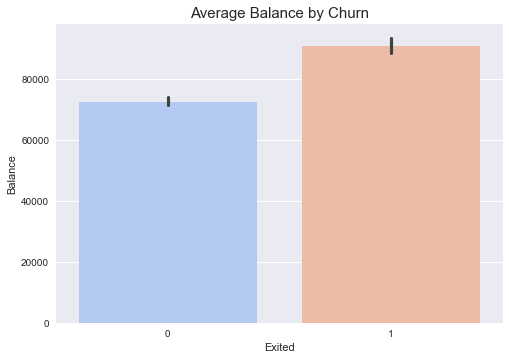

In [36]:
sns.barplot(x='Exited', y='Balance', data=df, palette='coolwarm')
plt.title('Average Balance by Churn', fontsize=15);

Looks like higher net worth individuals will churn on average. Could be due to attractive investment opportunities at a competitor.

In [211]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<img src='pandas-profile-corr-matrix.png' />

After running the pandas profile report, it has indicated that there is a high correlation between `NumOfProducts` and `Age`

<a id='analyse'></a>
# 3. Enrich and analyse data

Let's create a copy of our training DataFrame and enrich it with some engineered features. We will have an original training DataFrame and an engineered DataFrame. This gives us an option to run either with our models.

In [37]:
df_enriched = df.copy()

Let's put our credit scores into bins. We will use the VantageScore 3.0 (https://www.creditkarma.com/advice/i/credit-score-ranges) for our bins.

In [38]:
CreditScore_bin_list = []

for x in df_enriched['CreditScore']:
    if x >= 300 and x <= 600:
        score_bin = 'Poor'
    elif x >= 601 and x <= 660:
        score_bin = 'Fair'
    elif x >= 661 and x <= 780:
        score_bin = 'Good'
    elif x >= 781:
        score_bin = 'Excellent'
    else:
        score_bin = 'unknown'
    CreditScore_bin_list.append(score_bin)

df_enriched['CreditScore_bin'] = CreditScore_bin_list


Let's create a feature based on a customer's salary, compared to the average salary of that customer's country

In [39]:
# Create a new column that gets the average salaries by country and applies it to each customer
df_enriched['avg_country_sal'] = df_enriched.groupby('Geography')['EstimatedSalary'].transform('mean')

In [40]:
df_enriched['sal_to_avg'] = df_enriched['EstimatedSalary'] / df_enriched['avg_country_sal']

Now let's drop the average country salary column since we are done with it

In [41]:
df_enriched.drop('avg_country_sal', axis=1, inplace=True)

In [42]:
df_enriched.head()

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited CreditScore_bin  sal_to_avg  
0       1            Fair    1.014512  
1       0            Fair    1.131757  
2       1            Poor    1.140466  
3       0            Good    0.939213  
4       0       Excellent    0.795290

Let's discretize our Age, Balance, and EstimateSalary columns by putting them into bins

In [43]:
disc = EqualWidthDiscretiser(bins=10, variables = ['Age', 'Balance', 'EstimatedSalary'])

disc.fit(df_enriched)

EqualWidthDiscretiser(variables=['Age', 'Balance', 'EstimatedSalary'])

In [44]:
# Now transform our DataFrame
df_enriched = disc.transform(df_enriched)

In [45]:
df_enriched.head()

CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  Balance  \
0    15634602  Hargrave          619    France  Female    3       2        0   
1    15647311      Hill          608     Spain  Female    3       1        3   
2    15619304      Onio          502    France  Female    3       8        6   
3    15701354      Boni          699    France  Female    2       1        0   
4    15737888  Mitchell          850     Spain  Female    3       2        5   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  \
0              1          1               1                5       1   
1              1          0               1                5       0   
2              3          1               0                5       1   
3              2          0               0                4       0   
4              1          1               1                3       0   

  CreditScore_bin  sal_to_avg  
0            Fair    1.014512  
1            Fair    1.131757  
2            Poor    1.140466  
3            Good    0.939213  
4       Excellent    0.795290

We now have our Ages, Balances, Salaries in 10 bins, as well as some engineered features.

In [46]:
df_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  int64  
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  int64  
 12  Exited           10000 non-null  int64  
 13  CreditScore_bin  10000 non-null  object 
 14  sal_to_avg       10000 non-null  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 1.1+ MB


<a id='model'></a>
# 4. Model, predict, and evaluate

The objective is to predict if a customer is going to exit the bank. From the analysis above we know our target label ('Exited') is imbalanced towards **not exiting**. To compensate for this imbalance we will use the imbalanced-learn library to balance our data, and we will use LogisticRegression to setup a baseline model.

Let's use this function to evaluate our predictions:

In [47]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs y_pred labels
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    results = {"accuracy": round(accuracy, 2),
               "precision": round(precision, 2), 
               "recall": round(recall, 2),
               "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return results

This function will be used to plot ROC curves for model evaluation:

In [48]:
def plot_roc_curve(fpr, tpr):
    """
    Plots a ROC curve given the false positve rate (fpr) and 
    true postive rate (tpr) of a classifier.
    """
    # Plot ROC curve
    plt.plot(fpr, tpr, color='green', label='ROC')
    
    # Plot line with no predictive power (baseline)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Guess')
    
    # Customize the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15)
    plt.legend()
    plt.show()

Let's drop `CustomerId` and `Surname` as these unique ids should not impact our model. We will also drop `CreditScore` as we created a categorical column which contains the same information.

In [49]:
drop_features = ['CustomerId', 'Surname', 'CreditScore']

In [50]:
df_enriched.drop(drop_features, axis=1, inplace=True)

Now, let's take a quick look at our enriched DataFrame before modeling with it.

In [51]:
df_enriched

Geography  Gender  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0       France  Female    3       2        0              1          1   
1        Spain  Female    3       1        3              1          0   
2       France  Female    3       8        6              3          1   
3       France  Female    2       1        0              2          0   
4        Spain  Female    3       2        5              1          1   
...        ...     ...  ...     ...      ...            ...        ...   
9995    France    Male    2       5        0              2          1   
9996    France    Male    2      10        2              1          1   
9997    France  Female    2       7        0              1          0   
9998   Germany    Male    3       3        2              2          1   
9999    France  Female    1       4        5              1          1   

      IsActiveMember  EstimatedSalary  Exited CreditScore_bin  sal_to_avg  
0                  1                5       1            Fair    1.014512  
1                  1                5       0            Fair    1.131757  
2                  0                5       1            Poor    1.140466  
3                  0                4       0            Good    0.939213  
4                  1                3       0       Excellent    0.795290  
...              ...              ...     ...             ...         ...  
9995               0                4       0            Good    0.963678  
9996               1                5       0            Poor    1.018024  
9997               1                2       1            Good    0.421281  
9998               0                4       1            Good    0.918657  
9999               0                1       0       Excellent    0.382293  

[10000 rows x 12 columns]

In [52]:
df_enriched.columns

Index(['Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'CreditScore_bin', 'sal_to_avg'],
      dtype='object')

In [53]:
features = ['Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'CreditScore_bin', 'sal_to_avg']

In [54]:
X = df_enriched[features]
y = df['Exited']

Let's split our data into train and test.

In [55]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [56]:
# Check the shapes
X_train_full.shape, X_test.shape, y_train_full.shape, y_test.shape

((8000, 11), (2000, 11), (8000,), (2000,))

Let's split up our training data into train base and validation sets on the DataFrame with engineered features

In [57]:
# Let's split our training set for a basemodel validation set, adjust test_size to 25% to maintain the 20% split on the total set for val
X_train_base, X_val, y_train_base, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [58]:
# Check the shapes
X_train_base.shape, X_val.shape, y_train_base.shape, y_val.shape

((6000, 11), (2000, 11), (6000,), (2000,))

In [59]:
# Since our dataset is very imbalanced, let's resample using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_base, y_train_base)

#### Let's encode our categorical features so we can run our models

In [60]:
one_hot = OneHotEncoder()

one_hot.fit(X_train_resampled)

OneHotEncoder()

In [61]:
X_train_resampled = one_hot.transform(X_train_resampled)
X_val = one_hot.transform(X_val)


# Check the results
X_train_resampled.head()

Age  Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0    2       4        0              2          1               0   
1    3       7        4              1          1               0   
2    2       5        2              2          1               0   
3    1       1        4              1          1               1   
4    2       7        5              2          0               1   

   EstimatedSalary  sal_to_avg  Geography_France  Geography_Germany  \
0                9    1.990184                 1                  0   
1                0    0.049144                 0                  1   
2                1    0.364897                 0                  1   
3                8    1.796163                 1                  0   
4                8    1.752078                 0                  0   

   Geography_Spain  Gender_Male  Gender_Female  CreditScore_bin_Poor  \
0                0            1              0                     1   
1                0            1              0                     1   
2                0            1              0                     0   
3                0            0              1                     0   
4                1            1              0                     0   

   CreditScore_bin_Good  CreditScore_bin_Fair  CreditScore_bin_Excellent  
0                     0                     0                          0  
1                     0                     0                          0  
2                     1                     0                          0  
3                     1                     0                          0  
4                     1                     0                          0

#### Get our baseline model using LogisticRegression

In [62]:
# Setup the model
lr_baseline_model = LogisticRegression(random_state=42, max_iter=400)

# Train the model
lr_baseline_model.fit(X_train_resampled, y_train_resampled)

# Make a prediction
lr_baseline_y_preds = lr_baseline_model.predict(X_val)

lr_baseline_metrics = evaluate_preds(y_val, lr_baseline_y_preds)

Acc: 70.90%
Precision: 0.37
Recall: 0.67
F1 score: 0.47


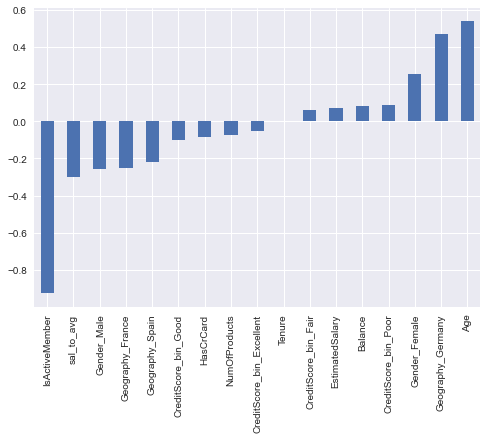

In [63]:
# Check LogisticRegression feature importance
pd.Series(lr_baseline_model.coef_[0], index=X_train_resampled.columns).sort_values().plot(kind='bar');

In [65]:
# To get the weights of all the variables
weights = pd.Series(lr_baseline_model.coef_[0], index=X_train_resampled.columns.values)
weights.sort_values(ascending = False)

Age                          0.538505
Geography_Germany            0.468707
Gender_Female                0.254448
CreditScore_bin_Poor         0.088086
Balance                      0.083959
EstimatedSalary              0.070997
CreditScore_bin_Fair         0.060325
Tenure                       0.002644
CreditScore_bin_Excellent   -0.050419
NumOfProducts               -0.073727
HasCrCard                   -0.082225
CreditScore_bin_Good        -0.098942
Geography_Spain             -0.216250
Geography_France            -0.253407
Gender_Male                 -0.255398
sal_to_avg                  -0.298793
IsActiveMember              -0.924382
dtype: float64

**Baseline results:** Our model accuracy score is 71%. `Age` and `Geography_Germany` appears to be the largest factor in determining our target label.

Let's run a cross val score to ensure we are getting a full representation of the model on the data:

In [66]:
cross_val_score(lr_baseline_model, X_train_resampled, y_train_resampled, cv=5).mean()

0.695570721550677

Our average cross validated score is 0.7

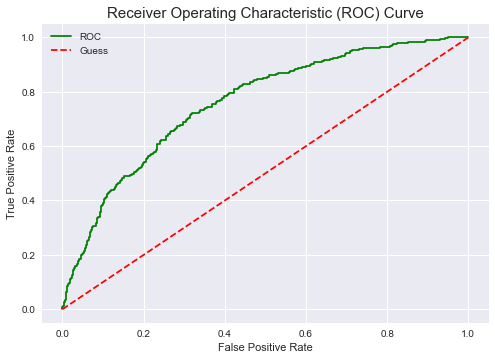

In [67]:
# Make predictions with probabilities
lr_baseline_y_probs = lr_baseline_model.predict_proba(X_val)

# Keep the probabilites of the positive class only
lr_baseline_y_probs = lr_baseline_y_probs[:, 1]

# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_val, lr_baseline_y_probs)

plot_roc_curve(fpr, tpr)

In [68]:
roc_auc_score(y_val, lr_baseline_y_probs)

0.7582776371187756

The baseline model's ROC curve score is 0.76. This definitely has room for improvement.

### GridSearchCV Model Validation

Now let's do some hyperparameter tuning using GridSearchCV.

In [70]:
parameters = [
             {
              'solver': ['lbfgs', 'newton-cg', 'sag'],
              'class_weight': [None, 'balanced'],
              'penalty': ['none', 'l2'],
              'max_iter': [400, 800],    
             },
             {
              'solver': ['liblinear', 'saga'],
              'class_weight': [None, 'balanced'],
              'penalty': ['l1', 'l2'],
              'max_iter': [400, 800],    
             }]
    

gs_model = LogisticRegression(random_state=42)

gs = GridSearchCV(gs_model, parameters, cv=5, verbose=2)

gs.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END class_weight=None, max_iter=400, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=400, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, 

The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=sag; total time=   0.5s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=sag; total time=   0.5s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=sag; total time=   0.5s
[CV] END class_weight=None, max_iter=400, penalty=l2, solver=sag; total time=   0.5s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=sag; total time=   0.5s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] 

The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=sag; total time=   0.5s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=sag; total time=   0.5s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=sag; total time=   0.5s
[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=sag; total time=   0.5s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=sag; total time=   0.5s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none, solver=newton-cg; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=none

The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=None, max_iter=400, penalty=l2, solver=saga; total time=   0.6s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=None, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=None, m

The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=saga; total time=   0.6s


The max_iter was reached which means the coef_ did not converge


[CV] END class_weight=balanced, max_iter=400, penalty=l2, solver=saga; total time=   0.6s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=saga; total time=   0.4s
[CV] END class_weight=balanced, max_iter=800, penalty=l1, solver=saga; tota

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid=[{'class_weight': [None, 'balanced'],
                          'max_iter': [400, 800], 'penalty': ['none', 'l2'],
                          'solver': ['lbfgs', 'newton-cg', 'sag']},
                         {'class_weight': [None, 'balanced'],
                          'max_iter': [400, 800], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear', 'saga']}],
             verbose=2)

In [71]:
gs.best_params_

{'class_weight': None, 'max_iter': 400, 'penalty': 'none', 'solver': 'lbfgs'}

In [72]:
best_gs_model = gs.best_estimator_
best_gs_model

LogisticRegression(max_iter=400, penalty='none', random_state=42)

In [73]:
gs_y_preds = best_gs_model.predict(X_val)

In [74]:
gs_metrics = evaluate_preds(y_val, gs_y_preds)

Acc: 70.90%
Precision: 0.37
Recall: 0.67
F1 score: 0.47


The GridSearchCV has found better hyperparameters. Our best model has returned an accuracy score of over 70% which is about the same as the baseline model.

Let's take a look at the confusion matrix and plot the ROC curve

In [75]:
# Visualize the Confusion Matrix
pd.crosstab(y_val, 
            gs_y_preds, 
            rownames=["Actual Label"], 
            colnames=["Predicted Label"])

Predicted Label     0    1
Actual Label              
0                1156  451
1                 131  262

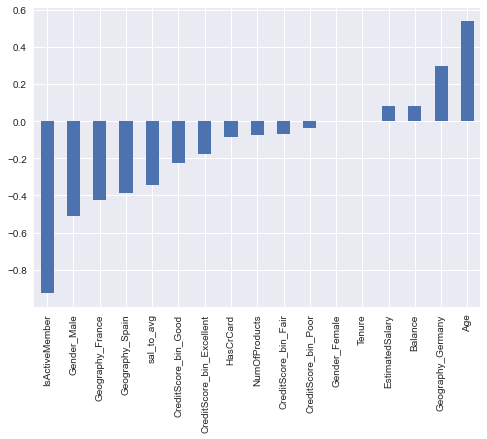

In [76]:
# Check the best_gs_model feature importance
pd.Series(best_gs_model.coef_[0], index=X_train_resampled.columns).sort_values().plot(kind='bar');

The best logistic regression model found by GridSearchCV appears to think the same features are important as our baseline model.

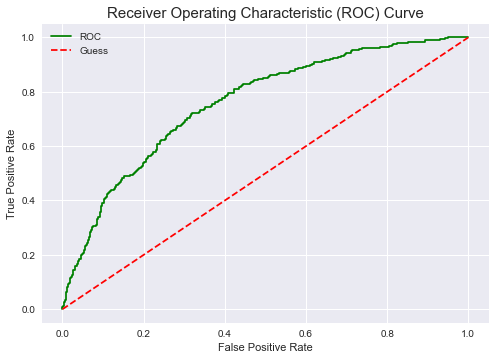

In [77]:
best_gs_model_y_probs = best_gs_model.predict_proba(X_val)

best_gs_model_y_probs = best_gs_model_y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, best_gs_model_y_probs)

plot_roc_curve(fpr, tpr)

In [78]:
roc_auc_score(y_val, best_gs_model_y_probs)

0.758174715897845

The best GridSearchCV model found has an ROC AUC score of 0.76. This is not an improvement from the baseline model of 0.76.
Let's try some more powerful, boosted models.

## XGBoost Model
Let's use XGBoost as an alternative model to LogisticRegression.

In [79]:
# Fitting XGBoost to the training data
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_resampled, y_train_resampled)
 
xgb_y_preds = xgb_model.predict(X_val)
 
# Visualize the Confusion Matrix
pd.crosstab(y_val, 
            xgb_y_preds, 
            rownames=["Actual Label"], 
            colnames=["Predicted Label"])

Predicted Label     0    1
Actual Label              
0                1395  212
1                 150  243

In [80]:
evaluate_preds(y_val, xgb_y_preds)

Acc: 81.90%
Precision: 0.53
Recall: 0.62
F1 score: 0.57


{'accuracy': 0.82, 'precision': 0.53, 'recall': 0.62, 'f1': 0.57}

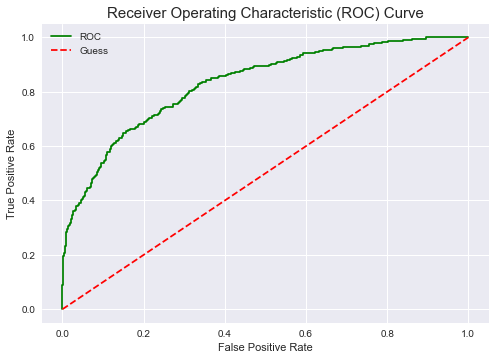

In [81]:
xgb_y_probs = xgb_model.predict_proba(X_val)

xgb_y_probs = xgb_y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, xgb_y_probs)

plot_roc_curve(fpr, tpr)

In [82]:
roc_auc_score(y_val, xgb_y_probs)

0.8307610945117655

The ROC AUC score performs much better than the best GridSearchCV Logistic Regression model we selected.

Let's check which features were most important in XGBoost:

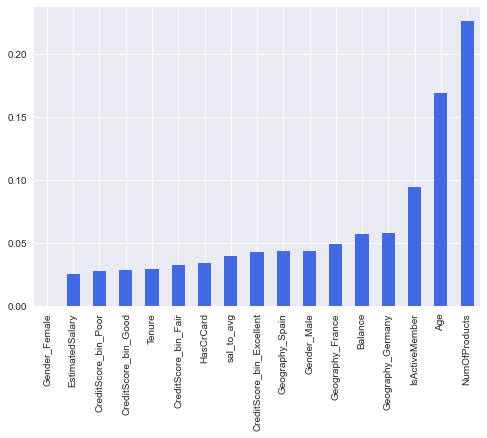

In [83]:
pd.Series(xgb_model.feature_importances_, index=X_train_resampled.columns).sort_values().plot(kind='bar', color=['royalblue']);

Let's use LIME to explain which features our XGB model thinks is important:

In [84]:
# Setup LIME object with feature / label names
explainer = LimeTabularExplainer(X_train_resampled.values,
                                 feature_names=X_train_resampled.columns.values,
                                 class_names=['Stayed', 'Exited'])

Let's look into which customers were predicted to stay, but actually left

In [85]:
X_val_copy = X_val.copy()

In [86]:
X_val_copy['prob_exited'] = xgb_y_probs
X_val_copy['actual_exited'] = y_val

X_val_copy[X_val_copy['actual_exited'] == 1].sort_values(by='prob_exited')

Age  Tenure  Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9784    2       4        0              2          1               0   
3547    2       6        0              2          0               0   
168     2       2        0              2          1               0   
5664    7       4        5              1          0               1   
8763    5       0        5              2          1               1   
...   ...     ...      ...            ...        ...             ...   
2750    5       9        0              3          1               1   
4677    4      10        4              3          0               1   
1657    4       6        5              3          1               0   
4563    6       3        6              3          0               0   
963     6       4        3              3          1               0   

      EstimatedSalary  sal_to_avg  Geography_France  Geography_Germany  \
9784                8    1.673518                 1                  0   
3547                0    0.024375                 0                  0   
168                 2    0.409503                 0                  0   
5664                4    0.949643                 0                  0   
8763                9    1.889195                 1                  0   
...               ...         ...               ...                ...   
2750                8    1.698906                 1                  0   
4677                7    1.565061                 0                  1   
1657                7    1.434738                 0                  1   
4563                7    1.449596                 0                  1   
963                 5    1.093447                 0                  0   

      Geography_Spain  Gender_Male  Gender_Female  CreditScore_bin_Poor  \
9784                0            1              0                     1   
3547                1            0              1                     0   
168                 1            0              1                     0   
5664                1            1              0                     0   
8763                0            1              0                     0   
...               ...          ...            ...                   ...   
2750                0            0              1                     1   
4677                0            0              1                     0   
1657                0            0              1                     0   
4563                0            0              1                     0   
963                 1            1              0                     1   

      CreditScore_bin_Good  CreditScore_bin_Fair  CreditScore_bin_Excellent  \
9784                     0                     0                          0   
3547                     1                     0                          0   
168                      1                     0                          0   
5664                     1                     0                          0   
8763                     1                     0                          0   
...                    ...                   ...                        ...   
2750                     0                     0                          0   
4677                     1                     0                          0   
1657                     1                     0                          0   
4563                     1                     0                          0   
963                      0                     0                          0   

      prob_exited  actual_exited  
9784     0.008444              1  
3547     0.008617              1  
168      0.010093              1  
5664     0.011594              1  
8763     0.013524              1  
...           ...            ...  
2750     0.999715              1  
4677     0.999845              1  
1657     0.999854              1  
4563     0.999952              1  
963      0.999971

In [87]:
# Pick a customer we want to analyse
cust_id = 6852

# Get the explanation of the 'black box' model
exp = explainer.explain_instance(X_val.loc[cust_id], xgb_model.predict_proba)

exp.show_in_notebook()

<img src='lime.PNG' />

Interpret the Model with SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


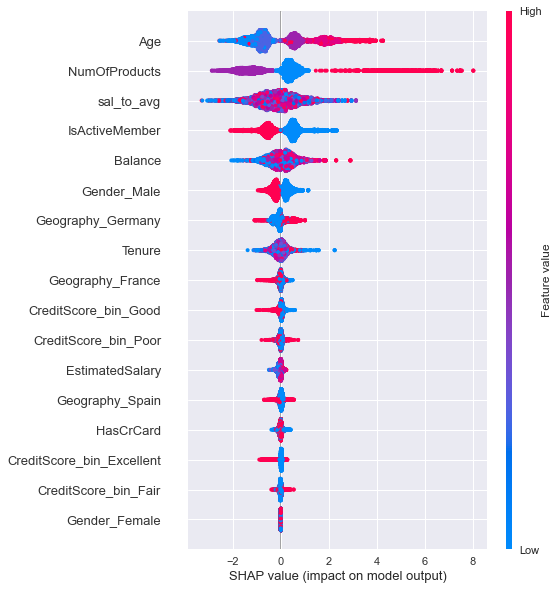

In [89]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_model, feature_perturbations = 'tree_path_dependent')
shap_values = explainer.shap_values(X_train_resampled)
shap.summary_plot(shap_values, X_train_resampled)

Plot the dependence plots for shap values and feature values

In [90]:
top_3_shap_features = ['Age', 'NumOfProducts', 'IsActiveMember']

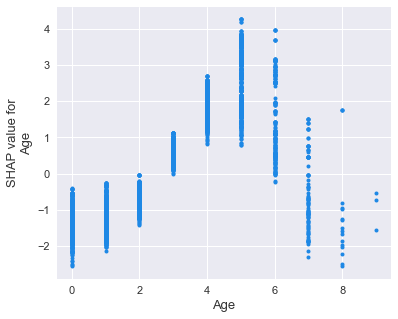

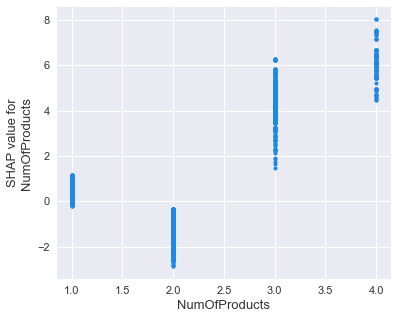

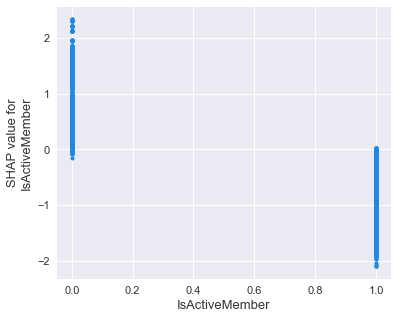

In [91]:
for feature in top_3_shap_features:
    shap.dependence_plot(
        feature,
        shap_values,
        X_train_resampled,
        interaction_index=None
    )

Looking at these dependence plots, the higher the SHAP value the greater the chance they will churn. So for `Age`, mid 40s to 60s (bins 4 - 6) shows a higher chance of churn. For `NumOfProducts` it looks like if a customer has too many products they could churn; the ideal count of products is 2. And for `IsActiveMember` we want to see customers active, they will have a lower chance of churning.

## LightGBM Model
Let's use LightGBM as another model.

In [92]:
# Fitting XGBoost to the training data
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train_resampled, y_train_resampled)
 
lgbm_y_preds = lgbm_model.predict(X_val)
 
# Visualize the Confusion Matrix
pd.crosstab(y_val, 
            lgbm_y_preds, 
            rownames=["Actual Label"], 
            colnames=["Predicted Label"])

Predicted Label     0    1
Actual Label              
0                1362  245
1                 126  267

In [93]:
evaluate_preds(y_val, lgbm_y_preds)

Acc: 81.45%
Precision: 0.52
Recall: 0.68
F1 score: 0.59


{'accuracy': 0.81, 'precision': 0.52, 'recall': 0.68, 'f1': 0.59}

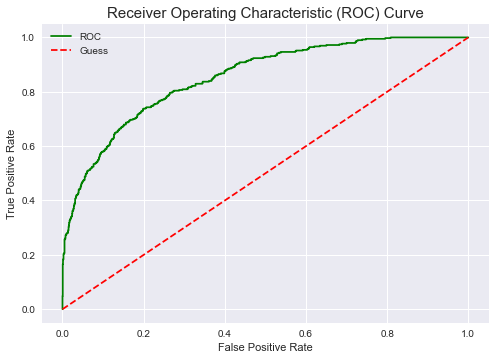

In [94]:
lgbm_y_probs = lgbm_model.predict_proba(X_val)

lgbm_y_probs = lgbm_y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, lgbm_y_probs)

plot_roc_curve(fpr, tpr)

In [95]:
roc_auc_score(y_val, lgbm_y_probs)

0.8528321544895028

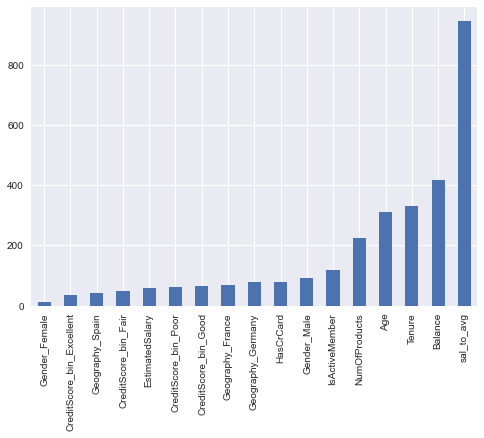

In [96]:
pd.Series(lgbm_model.feature_importances_, index=X_train_resampled.columns).sort_values().plot(kind='bar');

LightGBM actually produces the highest scores on our dataset. And our custom feature `sal_to_avg` was the most important feature it used to predict our target label.

### Identifying the top potential customers for the retention campaign

In [97]:
import scikitplot as skplt # For the lift curve plot

In [98]:
lgbm_y_probs = lgbm_model.predict_proba(X_val)

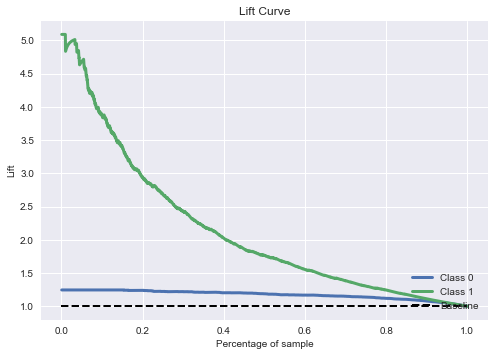

In [99]:
skplt.metrics.plot_lift_curve(y_val, lgbm_y_probs);

What does this lift curve mean?

It shows that for the first 20% of samples you will reach ~3 times more potential churners (this is the lift) than if you were contacting random clients.

Contacting the top 20% is a suggested option which will give an optimal return on investment for the rentention campaign.

Let's identify the top % of customers to contact:

In [100]:
df_contact = X_val.copy()
df_contact['y_val'] = y_val
df_contact['y_preds'] = lgbm_y_preds
df_contact['y_proba'] = lgbm_y_probs[:,1]

In [101]:
# Define threshold for top %
num_top = round(df_contact.shape[0]*0.2)

# Sort by probabilities
df_contact_top = df_contact.sort_values('y_proba', ascending=False)[:num_top]

In [102]:
# Finally, get the cusomter id in the dataframe to give the recommened top targets
df[['CustomerId']].merge(df_contact_top, left_index=True, right_index=True)

CustomerId  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
47      15771573    2       9        5              1          1   
56      15630053    3       5        5              1          1   
58      15623944    6       4        0              1          1   
126     15671137    4       1        0              1          0   
127     15782688    5       0        5              1          1   
...          ...  ...     ...      ...            ...        ...   
9820    15762762    3       5        4              1          0   
9884    15686974    4       4        0              1          0   
9917    15755731    4       8        4              1          0   
9929    15696388    2       4        4              1          1   
9963    15814664    2       2        5              1          1   

      IsActiveMember  EstimatedSalary  sal_to_avg  Geography_France  ...  \
47                 1                5    1.163276                 0  ...   
56                 0                4    0.871955                 1  ...   
58                 0                0    0.016524                 0  ...   
126                1                0    0.086448                 1  ...   
127                0                2    0.463085                 0  ...   
...              ...              ...         ...               ...  ...   
9820               0                2    0.510681                 0  ...   
9884               1                1    0.301955                 1  ...   
9917               1                6    1.222850                 0  ...   
9929               1                0    0.195453                 0  ...   
9963               0                6    1.353621                 0  ...   

      Geography_Spain  Gender_Male  Gender_Female  CreditScore_bin_Poor  \
47                  0            0              1                     0   
56                  0            1              0                     0   
58                  1            0              1                     1   
126                 0            0              1                     1   
127                 0            1              0                     0   
...               ...          ...            ...                   ...   
9820                0            0              1                     0   
9884                0            0              1                     0   
9917                0            1              0                     0   
9929                0            1              0                     0   
9963                0            1              0                     0   

      CreditScore_bin_Good  CreditScore_bin_Fair  CreditScore_bin_Excellent  \
47                       0                     1                          0   
56                       0                     1                          0   
58                       0                     0                          0   
126                      0                     0                          0   
127                      0                     1                          0   
...                    ...                   ...                        ...   
9820                     0                     1                          0   
9884                     1                     0                          0   
9917                     0                     1                          0   
9929                     1                     0                          0   
9963                     1                     0                          0   

      y_val  y_preds   y_proba  
47        1        1  0.734868  
56        0        1  0.735975  
58        1        1  0.961655  
126       1        1  0.796980  
127       1        1  0.966573  
...     ...      ...       ...  
9820      0        1  0.906268  
9884      1        1  0.874124  
9917      1        1  0.854581  
9929      0        1  0.625412  
9963      0        1  0.657277  

[400 rows x 21 columns]

A this point it would be a good idea to order by `Balance` or `sal_to_avg` and ask our retention department to focus on these high value clients.

## Model Stacking

Let's stack our top models and see if they can enhance each other.

In [103]:
estimators = [
    ('lr', best_gs_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
]

clf = StackingClassifier(
    estimators=estimators
)

clf.fit(X_train_resampled, y_train_resampled)

clf.score(X_val, y_val)

0.823

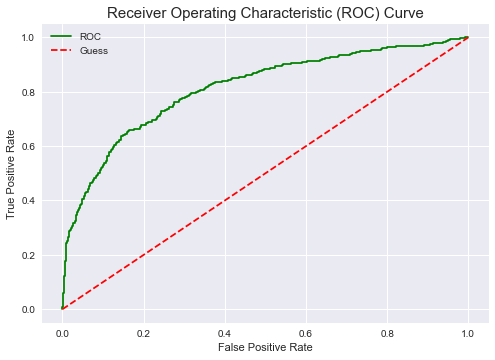

In [104]:
clf_y_probs = clf.predict_proba(X_val)

clf_y_probs = clf_y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, clf_y_probs)

plot_roc_curve(fpr, tpr)

In [105]:
roc_auc_score(y_val, clf_y_probs)

0.8126532932415593

Stacking our models did not help in this situation.

## Preprocessing our data with a Pipeline

Let's set our numeric and our categorical features from the training set

In [106]:
numeric_features = []

for label, content in X_train_full.items():
    if pd.api.types.is_numeric_dtype(content):
        numeric_features.append(label)

numeric_features

['Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'sal_to_avg']

In [107]:
categorical_features = []

for label, content in X_train_full.items():
    if pd.api.types.is_string_dtype(content):
        categorical_features.append(label)

categorical_features

['Geography', 'Gender', 'CreditScore_bin']

Let's setup a pipeline to preprocess our data before we load it into our model.

In [108]:
steps = [('mean_imp', SimpleImputer(strategy='most_frequent')),
         ('std_scaler', StandardScaler())]

numeric_pipeline = Pipeline(steps=steps)

In [109]:
steps = [('onehotenc', OneHotEncoder(drop_last=False))]

categorical_pipeline = Pipeline(steps=steps)

In [110]:
transformers = [('numeric_processing', numeric_pipeline, numeric_features),
                ('categorical_processing', categorical_pipeline, categorical_features)]

col_transformer = ColumnTransformer(transformers=transformers, remainder='drop')

In [111]:
steps=[('col_trans', col_transformer),
       ('lgbm', LGBMClassifier())]

final_pipeline = Pipeline(steps=steps)

In [112]:
final_pipeline.fit(X_train_full, y_train_full)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('numeric_processing',
                                                  Pipeline(steps=[('mean_imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary',
                                                   'sal_to_avg']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder())]),
                                                  ['Geography', 'Gender',
                                                   'CreditScore_bin'])])),
                ('lgbm', LGBMClassifier())])

In [113]:
y_pred = final_pipeline.predict(X_test)

In [114]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.47      0.58       407

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



In [115]:
evaluate_preds(y_test, y_pred)

Acc: 86.10%
Precision: 0.75
Recall: 0.47
F1 score: 0.58


{'accuracy': 0.86, 'precision': 0.75, 'recall': 0.47, 'f1': 0.58}

<a id='deep'></a>
# Deep learning model

Let's try a SKLearn Artificial Neural Network

In [116]:
nn = MLPClassifier((80, 80, 80, 80), activation='relu')

nn.fit(X_train_resampled, y_train_resampled)

MLPClassifier(hidden_layer_sizes=(80, 80, 80, 80))

In [117]:
nn.score(X_val, y_val)

0.8075

Let's try a Keras Sequential Deep Learning model

In [118]:
model = Sequential() # Initialize the model
model.add(Dense(25, input_dim=17, activation='relu')) # hidden layer, 17 neurons
model.add(Dense(25, activation='relu')) # hidden layer, 17 neurons
model.add(Dense(25, activation='relu')) # hidden layer, 17 neurons
model.add(Dense(2, activation='softmax')) # output layer, softmax will act as a sigmoid function with 2 classes, Ie. getting the highest probability generated

In [119]:
# Get the model ready
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [120]:
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, validation_data=(X_val, y_val)) #validation data is optional

Epoch 1/100
298/298 [==============================] - 1s 2ms/step - loss: 0.6707 - accuracy: 0.5899 - val_loss: 0.6505 - val_accuracy: 0.6440
Epoch 2/100
298/298 [==============================] - 0s 1ms/step - loss: 0.6180 - accuracy: 0.6696 - val_loss: 0.5705 - val_accuracy: 0.7425
Epoch 3/100
298/298 [==============================] - 0s 1ms/step - loss: 0.6025 - accuracy: 0.6834 - val_loss: 0.5464 - val_accuracy: 0.7580
Epoch 4/100
298/298 [==============================] - 0s 1ms/step - loss: 0.5953 - accuracy: 0.6886 - val_loss: 0.8479 - val_accuracy: 0.5045
Epoch 5/100
298/298 [==============================] - 0s 1ms/step - loss: 0.5880 - accuracy: 0.6934 - val_loss: 0.5587 - val_accuracy: 0.7325
Epoch 6/100
298/298 [==============================] - 0s 1ms/step - loss: 0.5838 - accuracy: 0.6933 - val_loss: 0.5319 - val_accuracy: 0.7450
Epoch 7/100
298/298 [==============================] - 0s 1ms/step - loss: 0.5824 - accuracy: 0.6958 - val_loss: 0.5921 - val_accuracy: 0.6955

Epoch 58/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4563 - accuracy: 0.7790 - val_loss: 0.4660 - val_accuracy: 0.7720
Epoch 59/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4555 - accuracy: 0.7821 - val_loss: 0.4545 - val_accuracy: 0.7805
Epoch 60/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.7799 - val_loss: 0.5388 - val_accuracy: 0.7395
Epoch 61/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4525 - accuracy: 0.7808 - val_loss: 0.3789 - val_accuracy: 0.8380
Epoch 62/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4538 - accuracy: 0.7821 - val_loss: 0.5416 - val_accuracy: 0.7300
Epoch 63/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4518 - accuracy: 0.7857 - val_loss: 0.5090 - val_accuracy: 0.7455
Epoch 64/100
298/298 [==============================] - 0s 1ms/step - loss: 0.4506 - accuracy: 0.7829 - val_loss: 0.4642 - val_accuracy:

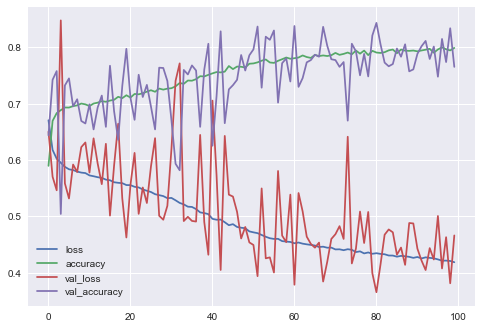

In [121]:
pd.DataFrame(history.history).plot();

In [122]:
# Run on the validation set now
model.evaluate(X_val, y_val)

63/63 [==============================] - 0s 924us/step - loss: 0.4663 - accuracy: 0.7655


[0.4663070738315582, 0.765500009059906]

In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                450       
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dense_3 (Dense)             (None, 2)                 52        
                                                                 
Total params: 1,802
Trainable params: 1,802
Non-trainable params: 0
_________________________________________________________________


<a id='report'></a>
# Report conclusion and final results

The banking customer data has given us a clear picture of what factors cause a customer to exit the bank. We engineered a couple of features and discretized our data which helped our models process the data and make accurate predictions.

After throughly testing out LogisticRegression models using GridSearchCV, we tried out a couple other models; XGBoost, LightGBM, and deep learning models MLPClassifier and Sequential.

We tuned and compared the models to find the best performing one and used it in a pipeline. Let's select our best performing model, save it for future use, and run a final test for our results.

### Saving the best model and running a final test
After testing out various models, I have selected the pipeline LGBClassifier model. We save the model for future use, reload it to ensure it was backed up properly, and run a final score on the test datasets that we separated out on our first split.

In [124]:
# Save the model
dump(final_pipeline, filename='churn_model_final.joblib') 

['churn_model_final.joblib']

In [125]:
# Import the model
imported_model = load('churn_model_final.joblib')

In [126]:
# Make and evaluate predictions with the imported model
new_y_preds = imported_model.predict(X_test)
evaluate_preds(y_test, new_y_preds)

Acc: 86.10%
Precision: 0.75
Recall: 0.47
F1 score: 0.58


{'accuracy': 0.86, 'precision': 0.75, 'recall': 0.47, 'f1': 0.58}

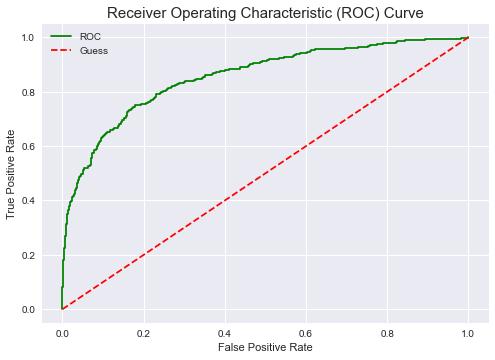

In [127]:
imported_model_y_probs = imported_model.predict_proba(X_test)

imported_model_y_probs = imported_model_y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, imported_model_y_probs)

plot_roc_curve(fpr, tpr)

In [128]:
roc_auc_score(y_test, imported_model_y_probs)

0.8559190932072287

Our baseline model had an accuracy of 70%, we have engineered features, tuned our hyperparameters, tried different models to an improved accuracy score of over 86%.

**Final accuracy: 86.05%**

**Final ROC AUC score: 0.86**